[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/MooseNeuro/moose-notebooks/blob/main/Direction_selectivity.ipynb) [![Binder](./binder_logo.png)](https://mybinder.org/v2/gh/MooseNeuro/moose-notebooks/HEAD?labpath=Direction_selectivity.ipynb)

In [1]:
## Only required on colab! Uncomment to enable.
# !pip install pymoose --quiet

In [2]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

import moose

What is the point of neurons having elaborate dendritic trees? [Wilfrid Rall](https://en.wikipedia.org/wiki/Wilfrid_Rall) (1922-2018) analyzed how input at different regions of the dendritic tree influence the soma. Here we will implement a simple model described in Rall 1964. This paper is freely available in the book [The Theoretical Foundation of Dendritic Function: The Collected Papers of Wilfrid Rall with Commentaries](https://direct.mit.edu/books/oa-edited-volume/2066/The-Theoretical-Foundation-of-Dendritic)

This is a passive model. We will start with the specific values of the membrane properties.

In [3]:
RM = 0.4 # specific membrane resistivity unit: Ohm m2
RA = 1.0 # specific cytoplasmic resistivity unit: Ohm m
CM = 0.01 # specific membrane capacitance unit: Farad/m2

Next we will specify the compartment dimensions. As described in the cable theory tutorial, the spatial changes in the electrical signal are determined by the space constant. Rall described his model in terms of space constan $\lambda$. 
Therefore we will arbitrarily pick 1 $\mu m$ as the diameter of the compartment, and then compute the length from the space constant. Rall used 10 compartments of $0.2 \lambda$ length in his model.

In [4]:
diameter = 1e-6

# Space constant
lambda_ = np.sqrt(0.25 * diameter * RM/RA)  

# Membrane time constant
tau = RM * CM                   

# Rall used 10 compartments of `0.2 * lambda` length each
length = 0.2 * lambda_ 

Now we set the passive properties of the compartments.

In [5]:
Em = -65e-3         # Leak reversal potential
Rm = RM / (np.pi * diameter * length)         # Total membrane resistance
Cm = CM * (np.pi * diameter * length)         # Total membrane capacitance

# Ra is the total axial (cytoplasmic) resistance between successive compartments
Ra = RA * length / (np.pi * diameter * diameter / 4.0)        

# Ek is the reversal potential of the synaptic channels. 
# We make it 1 mV above the resting membrane potential.
Ek = Em + 1e-3

print('tau =', tau, 'lambda =', lambda_)

tau = 0.004 lambda = 0.00031622776601683794


Next we set the simulation time $2.5\tau$, where $\tau$ is the membrane time constant. And we set the current injection onset to $0.25 \tau$.

In [6]:
simtime = 2.5 * tau
inject_time = 0.25 * tau

With all the parameters set up, we can go onto creating the containers for model and data.

In [7]:
model = moose.Neutral('/model')
data = moose.Neutral('/data')


Now we use the property values defined above to create 10 compartments and connect them sequentially to make a linear cable. 

*Note for Jupyter notebook: Do not run this cell multiple times, because that will create additional connections between the compartments on each run. Instead restart the kernel and rerun all the cells up to here*

In [8]:
num_comp = 10
comps = []
for ii in range(num_comp):
    comp = moose.Compartment(f'{model.path}/comp_{ii}')
    # If there is at least one compartment already, 
    # connect the current one to the last one via axial resistance
    if len(comps) > 0:
        moose.connect(comps[-1], 'raxial', comp, 'axial')
    comps.append(comp)
    comp.Em = Em
    comp.Rm = Rm
    comp.Ra = Ra
    comp.Cm = Cm
    comp.initVm = Em

We will record the voltage signal at the soma (`comp_0`)

In [9]:
soma_vm = moose.Table(f'{data.path}/soma_Vm')
moose.connect(soma_vm, 'requestOut', comps[0], 'getVm')

<moose.SingleMsg id=5 dataIndex=9 path=/Msgs[0]/singleMsg[9]>

## Importance of spatial location of input

He first showed that inputs at different distances from the soma  have different effects at the soma depending on how far they are from the soma. 


Figure 6 in his article (Rall 1964) shows the EPSP evoked at the soma by input at four different locations.

Rall used a coarse approximation of synaptic input as an additional inward voltage. We can implement this using the `Leakage` channel in moose with slightly positive reversal potential (`Ek`) than the resting membrane potential. When the conductance of the channel is `0`, it is effectively disconnected. When it is nonzero, it is applying the inward voltage on the compartment. Therefore we shall setup `Leakage` channels for each compartment.


In [10]:
chans = []
for ii in range(num_comp):
    chan = moose.Leakage(f'{comps[ii].path}/chan')
    chan.Ek = Ek
    chan.Gbar = 0.0
    moose.connect(chan, 'channel', comps[ii], 'channel')
    chans.append(chan)

In one case (Fig 6A in the paper) he applied these on the first two compartemnts closest to the soma, i.e., `comp_1` and `comp_2`.

Now we will run the simulation for a short duration ($0.25\tau$), setting the channel conductances (`Gbar`) to $\frac{1}{Rm}$. This is a proxy for a synaptic input at the onset of the simulation. 


In [11]:
chans[1].Gbar = 1 / Rm
chans[2].Gbar = 1 / Rm

moose.reinit()
moose.start(inject_time)

Now we will switch off channels by setting their maximal conductances to `0` and run the rest of the simulation.

In [12]:
chans[1].Gbar = 0
chans[2].Gbar = 0
moose.start(simtime - inject_time)

Finally we will plot the soma voltage against time.

Text(0.5, 1.0, 'Figure 6A from Rall 1964')

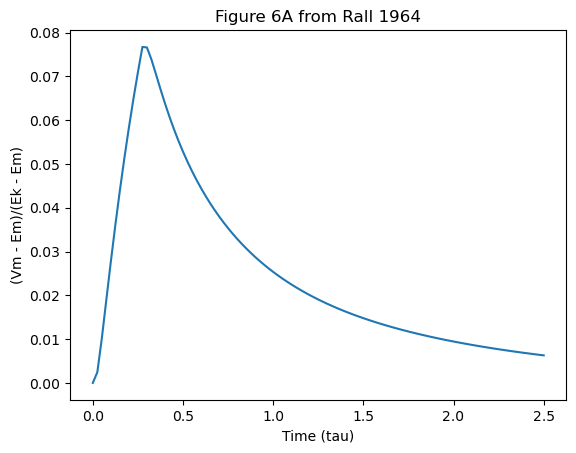

In [13]:
t = np.linspace(0, 2.5, len(soma_vm.vector))  # Time in units of tau
vm_6a = (soma_vm.vector - Em) / (Ek - Em)     # Vm deflection scaled by the additional electromotive force
plt.plot(t, vm_6a)
plt.ylabel('(Vm - Em)/(Ek - Em)')
plt.xlabel('Time (tau)')
plt.title('Figure 6A from Rall 1964')

Then he activated the next two compartments (Fig 6B)

In [14]:
chans[3].Gbar = 1 / Rm
chans[4].Gbar = 1 / Rm

moose.reinit()
moose.start(inject_time)

chans[3].Gbar = 0
chans[4].Gbar = 0

moose.start(simtime - inject_time)

Text(0.5, 1.0, 'Figure 6B from Rall 1964')

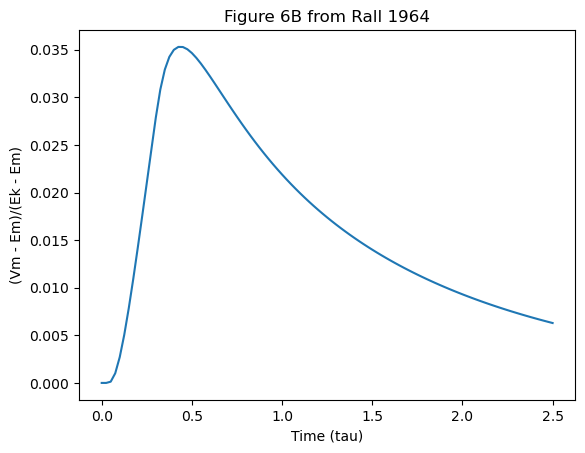

In [15]:
t = np.linspace(0, 2.5, len(soma_vm.vector))  # Time in units of tau
vm_6b = (soma_vm.vector - Em) / (Ek - Em)     # Vm deflection scaled by the additional electromotive force
plt.plot(t, vm_6b)
plt.ylabel('(Vm - Em)/(Ek - Em)')
plt.xlabel('Time (tau)')
plt.title('Figure 6B from Rall 1964')

In [16]:
chans[5].Gbar = 1 / Rm
chans[6].Gbar = 1 / Rm

moose.reinit()
moose.start(inject_time)

chans[5].Gbar = 0
chans[6].Gbar = 0

moose.start(simtime - inject_time)

Text(0.5, 1.0, 'Figure 6C from Rall 1964')

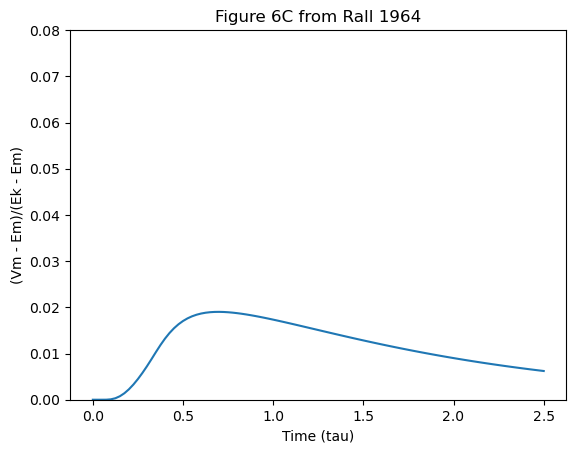

In [17]:
t = np.linspace(0, 2.5, len(soma_vm.vector))  # Time in units of tau
vm_6c = (soma_vm.vector - Em) / (Ek - Em)     # Vm deflection scaled by the additional electromotive force
plt.plot(t, vm_6c)
plt.ylabel('(Vm - Em)/(Ek - Em)')
plt.xlabel('Time (tau)')
plt.ylim(0, 0.08)  # Ensure the same y-scale
plt.title('Figure 6C from Rall 1964')

In [18]:
chans[7].Gbar = 1 / Rm
chans[8].Gbar = 1 / Rm

moose.reinit()
moose.start(inject_time)

chans[7].Gbar = 0
chans[8].Gbar = 0

moose.start(simtime - inject_time)

Text(0.5, 1.0, 'Figure 6D from Rall 1964')

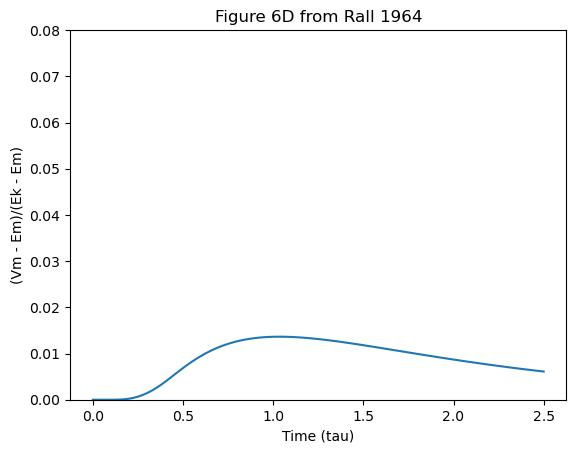

In [19]:
t = np.linspace(0, 2.5, len(soma_vm.vector))  # Time in units of tau
vm_6d = (soma_vm.vector - Em) / (Ek - Em)     # Vm deflection scaled by the additional electromotive force
plt.plot(t, vm_6d)
plt.ylabel('(Vm - Em)/(Ek - Em)')
plt.xlabel('Time (tau)')
plt.ylim(0, 0.08)  # Ensure the same y-scale
plt.title('Figure 6D from Rall 1964')

## Spatio-temporal patterns

Next, Rall went on to stimulate these inputs sequentially. Thus the four pairs of channels were activated successively in the same simulation. He tested two scenarios: centrifugal and centripetal inputs. 

In the centrifugal case, the input starts close to soma and moves away with time. Thus the channels closest to the soma are first activated, then the next two, then the next two, etc.

Centripetal inputs start far from the soma and moves towards the soma with time. Here the channels farthest from the soma are first activated, then the next closer pair, and so on. 

For this we can use the same strategy as above, but we shall not `reinit` between activation of successive `Leakage` channels.

In [20]:
moose.reinit()
time_left = simtime
for ii in range(1, 9, 2):
    chans[ii].Gbar = 1 / Rm
    chans[ii+1].Gbar = 1 / Rm
    moose.start(inject_time)
    time_left = time_left - inject_time
    chans[ii].Gbar = 0
    chans[ii+1].Gbar = 0
    print('Input delivered at', ii, 'and', ii+1)
moose.start(time_left)

Input delivered at 1 and 2
Input delivered at 3 and 4
Input delivered at 5 and 6
Input delivered at 7 and 8


Text(0.5, 1.0, 'Figure 7D from Rall 1964')

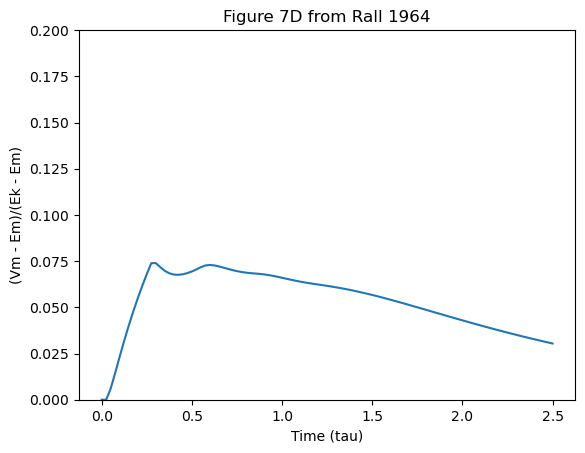

In [21]:
t = np.arange(0, len(soma_vm.vector)) * soma_vm.dt  # Time 
vm_7_abcd = (soma_vm.vector - Em) / (Ek - Em)     # Vm deflection scaled by the additional electromotive force
plt.plot(t / tau, vm_7_abcd)
plt.ylabel('(Vm - Em)/(Ek - Em)')
plt.xlabel('Time (tau)')
plt.ylim(0, 0.2)  # Ensure the same y-scale
plt.title('Figure 7D from Rall 1964')

In [22]:
moose.reinit()
time_left = simtime
for ii in range(8, 1, -2):
    chans[ii].Gbar = 1 / Rm
    chans[ii-1].Gbar = 1 / Rm
    moose.start(inject_time)
    time_left = time_left - inject_time
    chans[ii].Gbar = 0
    chans[ii-1].Gbar = 0
    print('Input delivered at', ii-1, 'and', ii)
moose.start(time_left)

Input delivered at 7 and 8
Input delivered at 5 and 6
Input delivered at 3 and 4
Input delivered at 1 and 2


Text(0.5, 1.0, 'Figure 7D from Rall 1964')

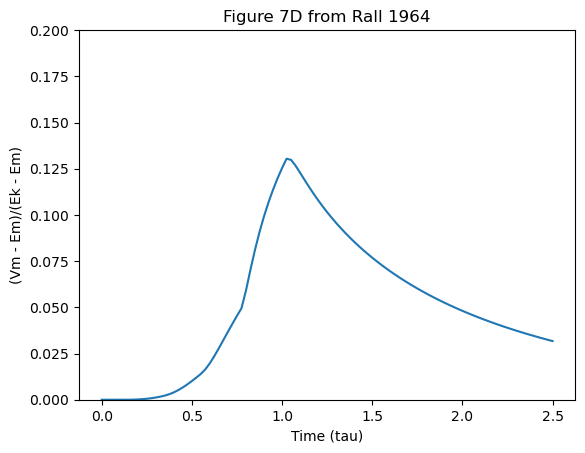

In [24]:
t = np.arange(0, len(soma_vm.vector)) * soma_vm.dt  # Time 
vm_7_dcba = (soma_vm.vector - Em) / (Ek - Em)     # Vm deflection scaled by the additional electromotive force
plt.plot(t / tau, vm_7_dcba)
plt.ylabel('(Vm - Em)/(Ek - Em)')
plt.xlabel('Time (tau)')
plt.ylim(0, 0.2)  # Ensure the same y-scale
plt.title('Figure 7D from Rall 1964')

As we can see, the centripetal input sequence produces a larger depolarization at the soma compared to a centripetal input sequence. Thus the direction of the input sequence on dendrites matters for neural computation.

## Ion channel distribution and dendritic integration